In [77]:
import sys

sys.path.append("../")

import MetaTrader5 as mt5
import pytz
import numpy as np
import pandas_ta as ta

from datetime import datetime
from terminal.Extensions.Mt5Helper import Mt5Helper

In [78]:
mt5.initialize()

True

In [79]:
from_date = datetime(2024, 5, 22, tzinfo=pytz.utc)
to_date = datetime(
    from_date.year, from_date.month, from_date.day, 17, 59, 59, 0, tzinfo=pytz.utc
)

In [80]:
data = mt5.copy_ticks_range("WINM24", from_date, to_date, mt5.COPY_TICKS_TRADE)

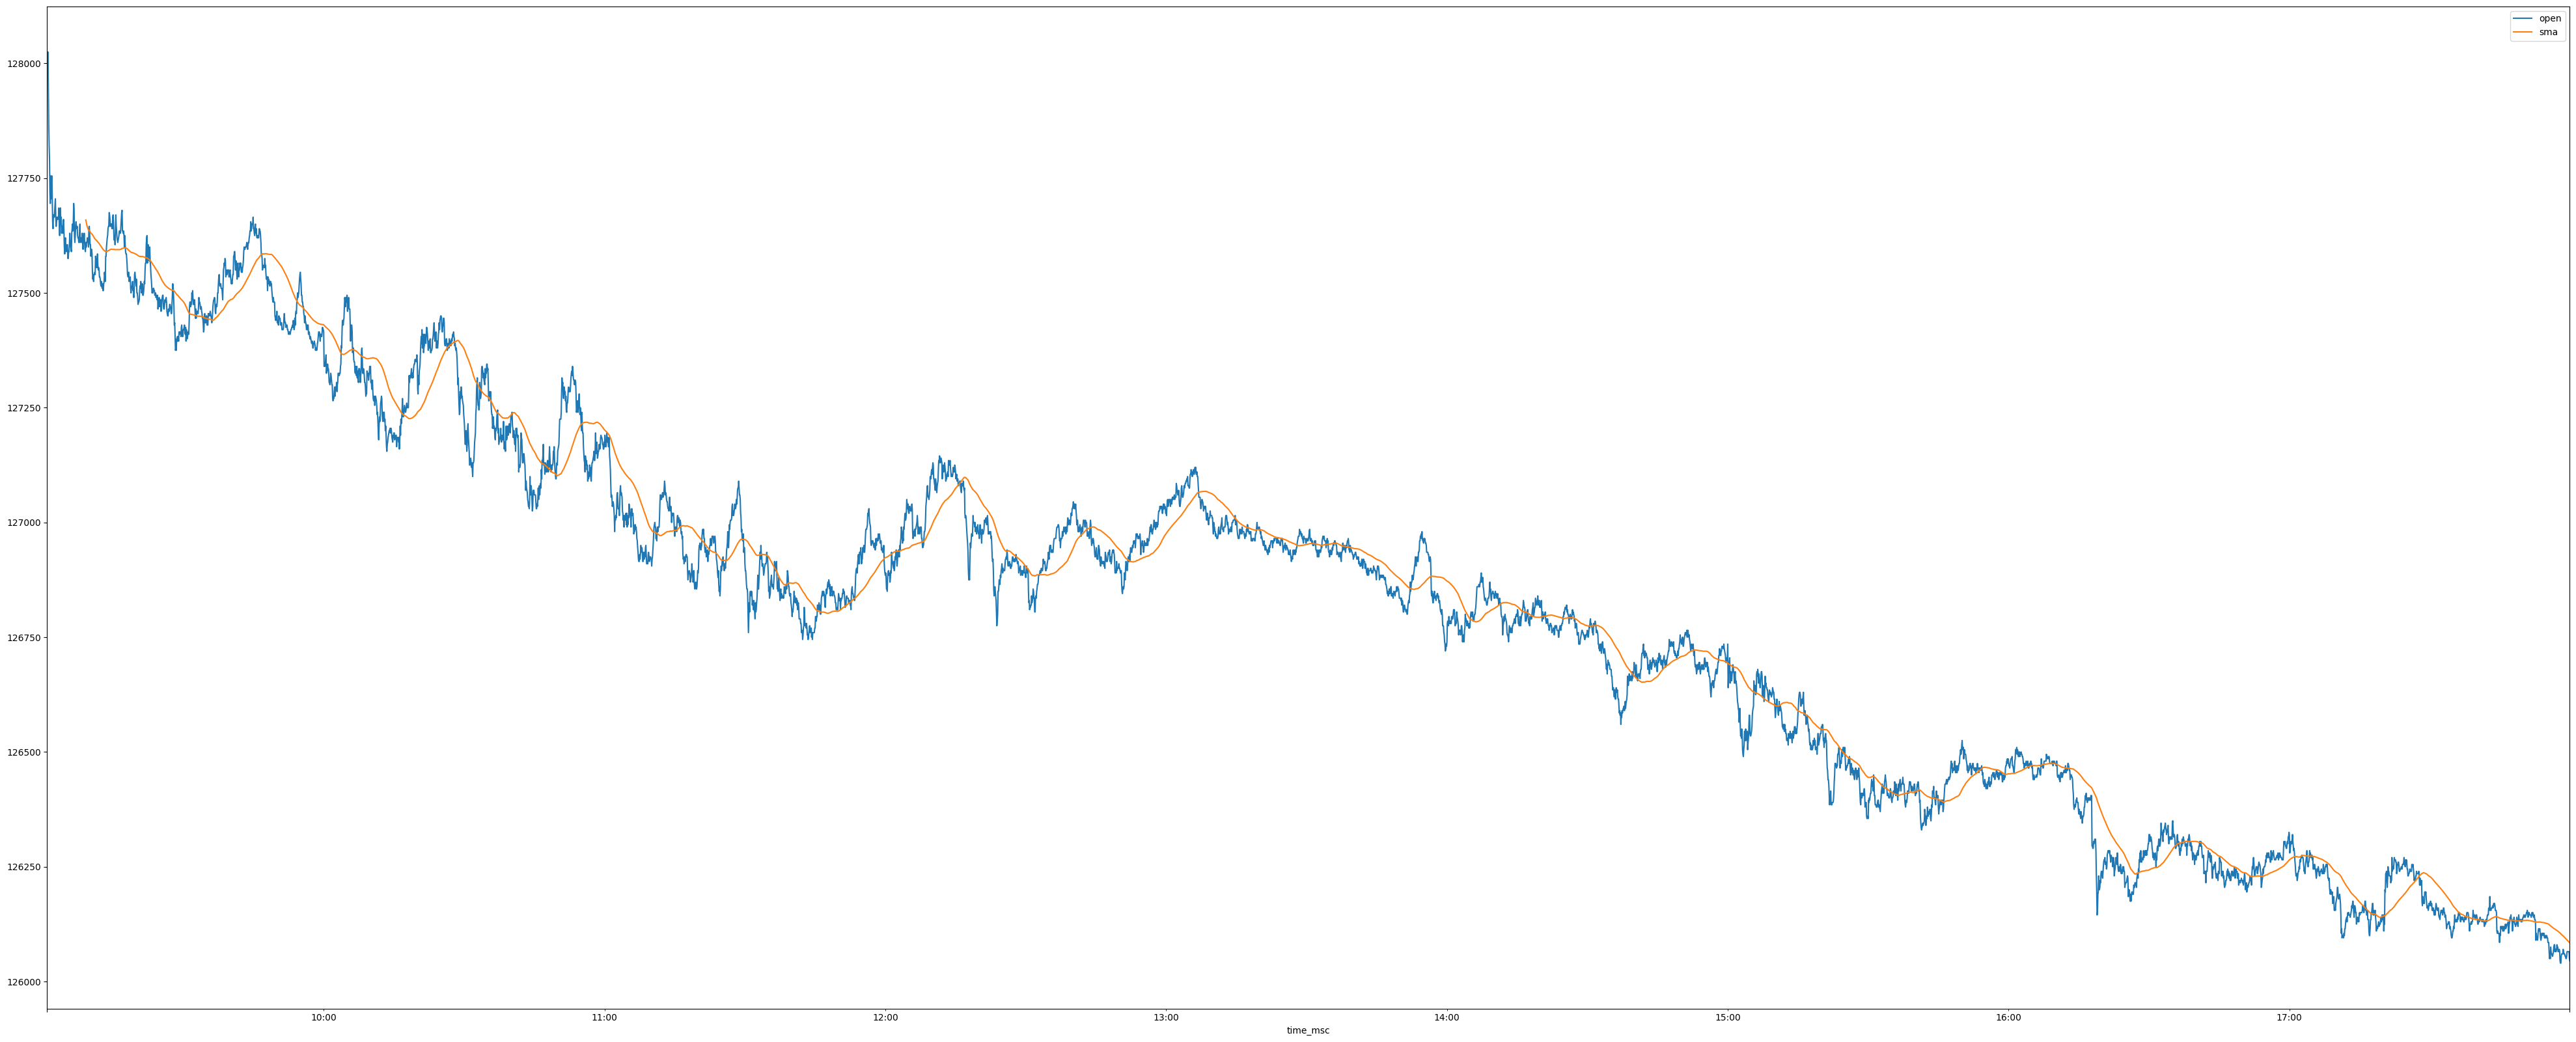

In [81]:
rates = Mt5Helper.OHLC(data, "5s")

rates.index = rates.index.tz_localize(None)

rates["sma"] = rates["open"].rolling(100).mean()

def plot_rates(length):
    rates.iloc[0:length][["open", "sma"]].plot(
        subplots=[("open", "sma")],
        figsize=(50, 20),
    )


plot_rates(length=None)

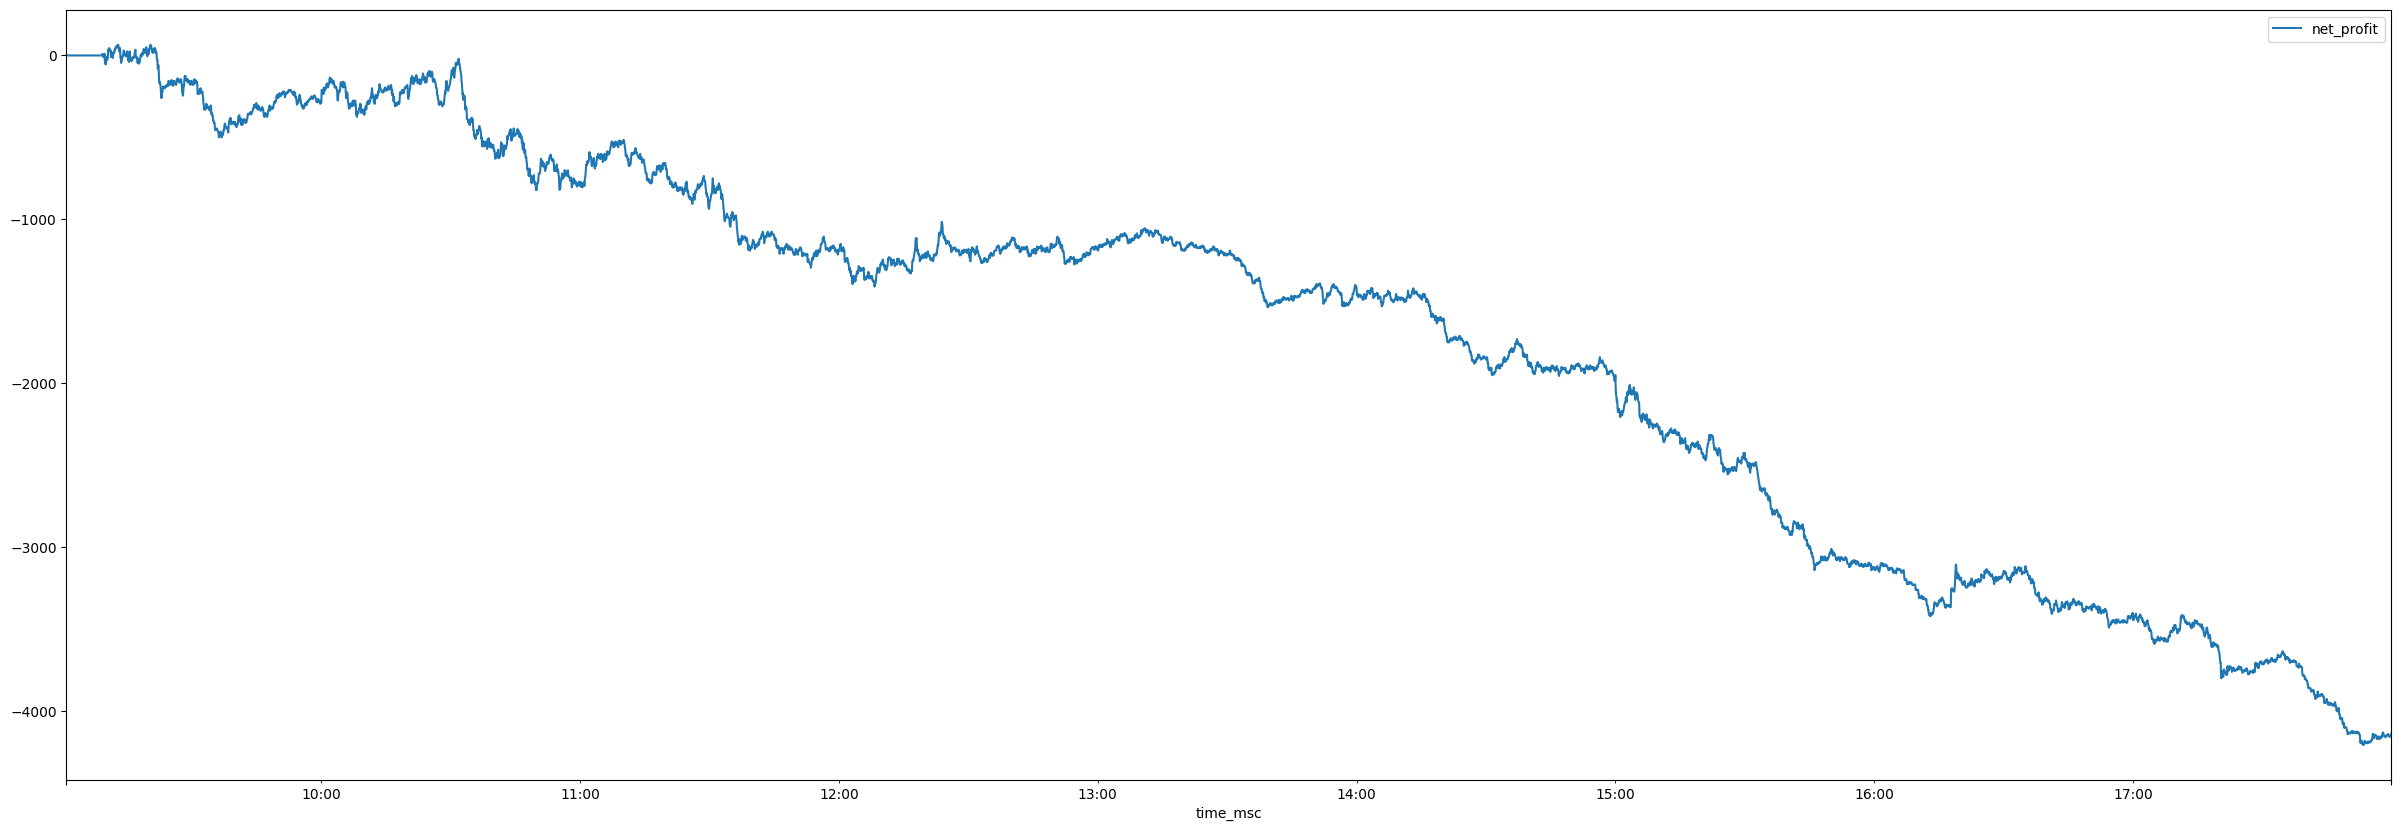

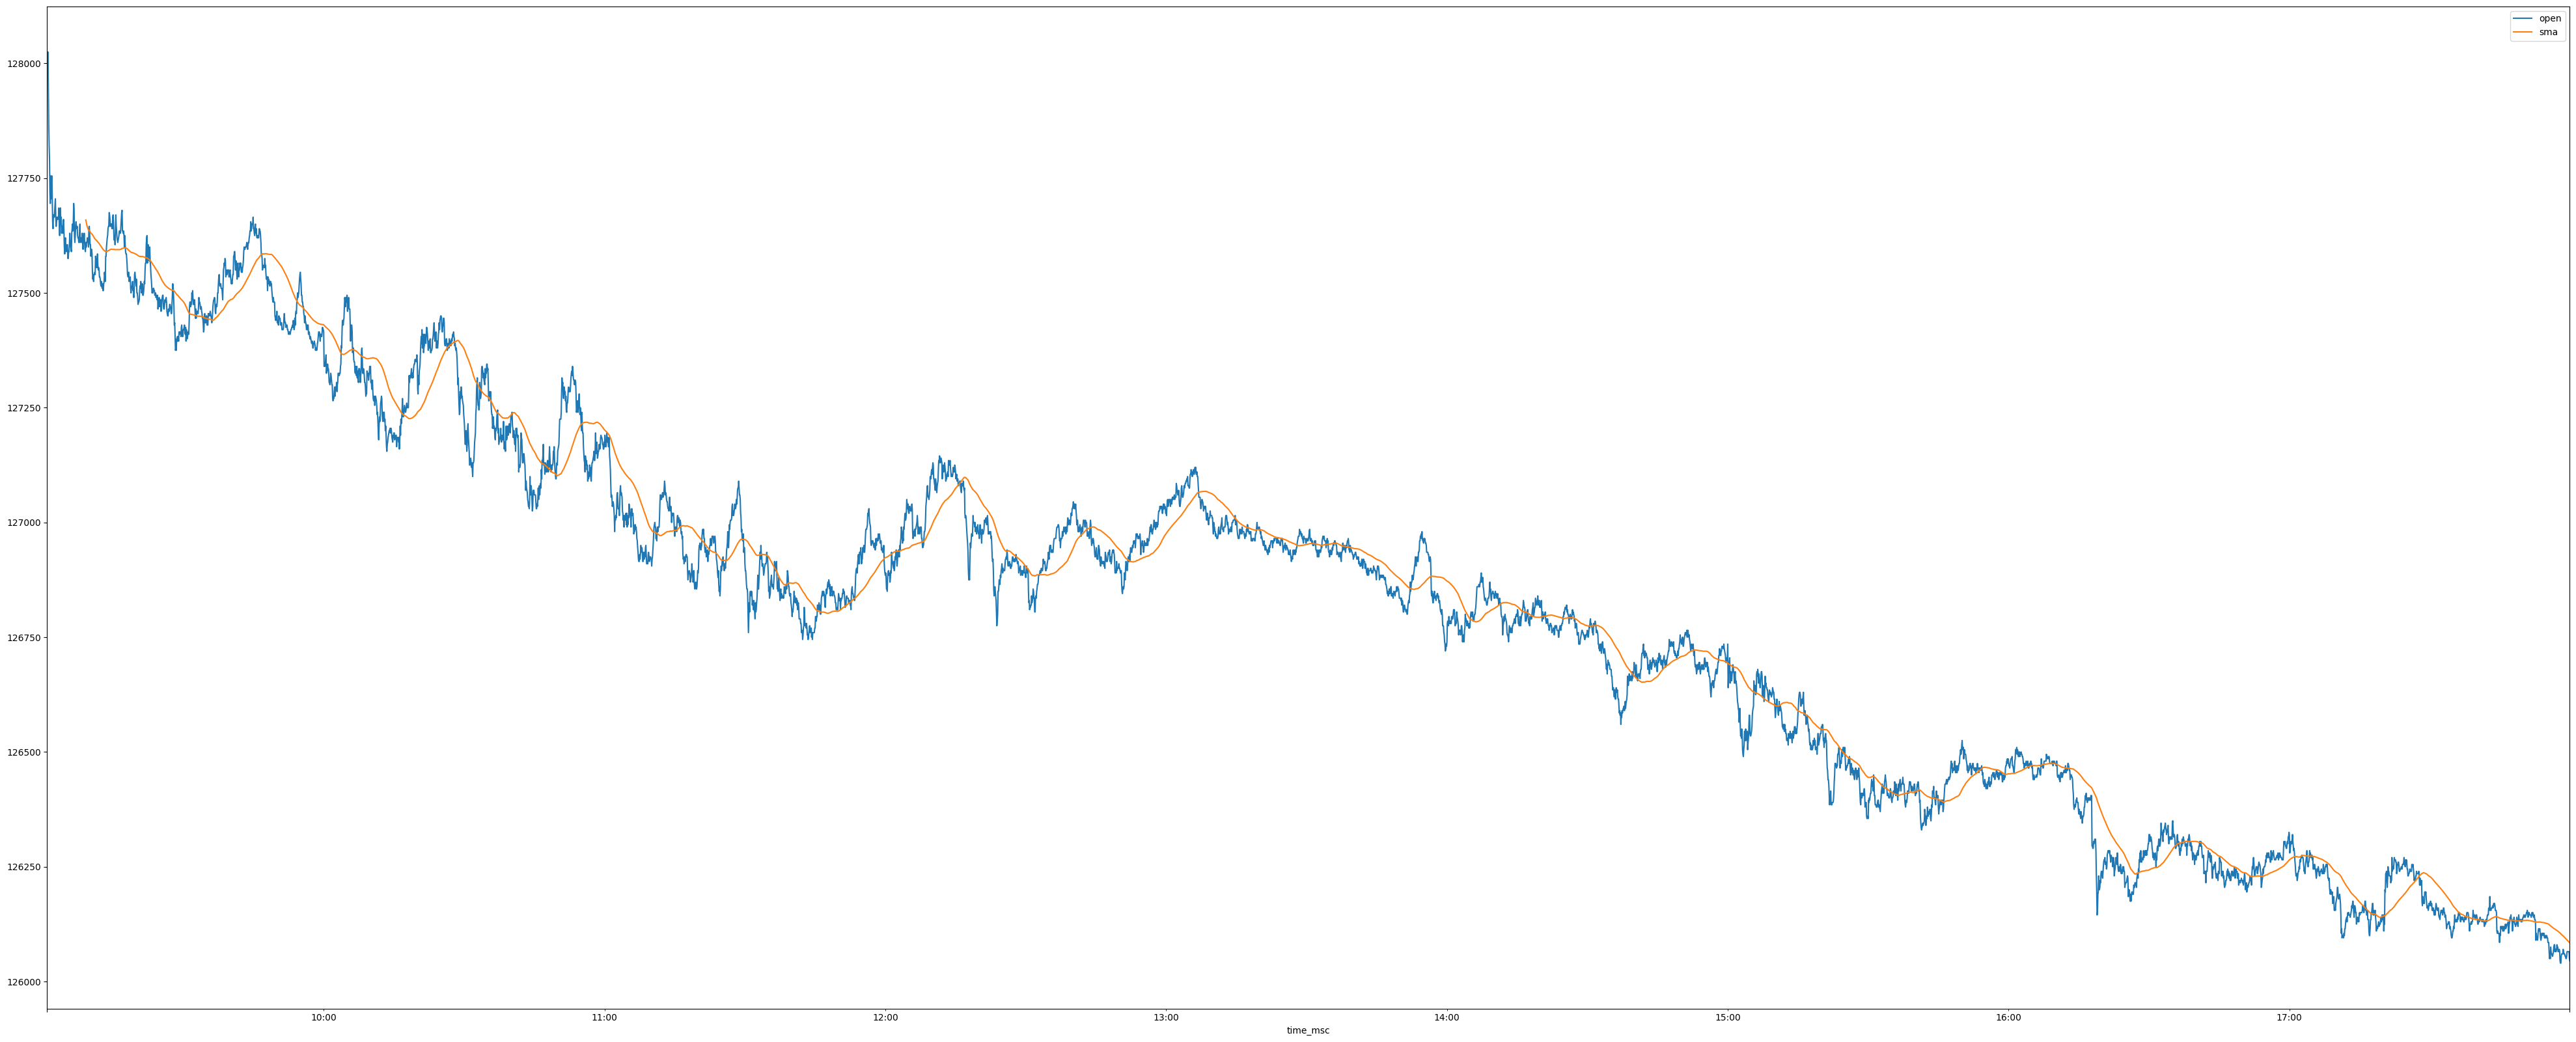

In [84]:
sum_buy = 0
buy_qty = 0
buy_avg = 0
buy_profit = 0

sum_sell = 0
sell_qty = 0
sell_avg = 0
sell_profit = 0

net_qty = 0
net_profit = 0

used_slippage = 0
slippage = 5

trend = True


def update(i):
    rates.loc[i, "sum_buy"] = sum_buy
    rates.loc[i, "buy_qty"] = buy_qty
    rates.loc[i, "buy_avg"] = buy_avg
    rates.loc[i, "buy_profit"] = buy_profit
    rates.loc[i, "sum_sell"] = sum_sell
    rates.loc[i, "sell_qty"] = sell_qty
    rates.loc[i, "sell_avg"] = sell_avg
    rates.loc[i, "sell_profit"] = sell_profit
    rates.loc[i, "net_qty"] = net_qty
    rates.loc[i, "net_profit"] = net_profit
    rates.loc[i, "slippage"] = used_slippage


for i, item in rates.iterrows():
    if np.isnan(item.open):
        update(i)
        continue

    used_slippage = slippage

    # sinal de compra
    if net_qty <= 0 and item.open > item.sma:
        qty =  abs(net_qty) + 1
        sum_buy += qty * item.open + used_slippage
        buy_qty += qty

    # sinal de venda
    if net_qty >= 0 and item.open < item.sma:
        qty = abs(net_qty) + 1
        sum_sell += qty * item.open - used_slippage
        sell_qty += qty

    buy_avg = 0 if sum_buy == 0 else sum_buy / buy_qty
    sell_avg = 0 if sum_sell == 0 else sum_sell / sell_qty

    buy_profit = 0 if buy_qty == 0 else (item.open - used_slippage - buy_avg) * buy_qty
    sell_profit = (
        0 if sell_qty == 0 else (sell_avg - item.open + used_slippage) * sell_qty
    )

    net_avg = 0
    net_qty = buy_qty - sell_qty
    net_profit = buy_profit + sell_profit

    update(i)


rates[["net_profit"]].plot(figsize=(30, 10))

plot_rates(None)

In [83]:
rates.to_excel("output.xlsx")